# Bachelor thesis project on duplicate detection methods for historical VOC data

Chris van Schagen

Student number: 14228823

This notebook creates and evaluates three methods for duplicate detection on historical Dutch documents: TF-IDF, BiLSTM, and a Hybrid approach. The data used for this project can be found and downloaded here: GLOBALISE project, 2024, "VOC transcriptions v2 - GLOBALISE", https://hdl.handle.net/10622/LVXSBW, IISH Data Collection, V1.

Additionally, to locate the exact documents within those transcription archives, the csv file "NT00348_OBP" is used, which is included in this repository.

For the BiLSTM and Hybrid models, pre trained embeddings are used. The embeddings are pretrained using the Word2Vec model by GLOBALISE (van Wissen, Leon, and GLOBALISE. “GLOBALISE Word2vec Experiment”. Zenodo, March 17, 2025. https://doi.org/10.5281/zenodo.15038313.) The embedding matrix loaded here was trained with different parameter values as originally in their experiment. Such as the context window or the minimum amount of occurences of a word. The exact details about this are explained in the thesis.

The contents of this notebook are as follows:

- [Imports](#imports)
- [Data Collection](#data-collection)
- [Defining Functions](#defining-functions)
- [Data Preprocessing and Subset Selection](#data-preprocessing-and-subset-selection)
- [TF-IDF Model](#tf-idf-model)
    - [Potential (near)-duplicates evaluation](#evaluating-tf-idfs-similar-pairs)
    - [Saving confirmed results](#saving-tf-idfs-near-duplicates-to-csv-files)
- [BiLSTM Model](#bilstm-model)
    - [Potential (near)-duplicates evaluation](#evaluating-bilstms-similar-pairs)
    - [Saving confirmed results](#saving-bilstms-near-duplicates-to-csv-files)
- [Hybrid Model](#hybrid-model)
    - [Potential (near)-duplicates evaluation](#evaluating-hybrids-similar-pairs)
    - [Saving confirmed results](#saving-hybrids-near-duplicates-to-csv-files)
- [Synthetic dataset](#synthetic-dataset)
    - [TF-IDF model evaluation](#synthetic-dataset-tf-idf-evaluation)
    - [BiLSTM model evaluation](#synthetic-dataset-bilstm-evaluation)
    - [Hybrid model evaluation](#synthetic-dataset-hybrid-evaluation)

## Imports

In [ ]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from tqdm import tqdm
import os
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_punctuation
from gensim.utils import deaccent, simple_tokenize

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

## Data collection

This creates a dataframe of document id's, inventory numbers, start and end pages. The necessary information about the documents is loaded from the csv file "NT00348_OBP". The inventory numbers that reference the correct TXT file containing the document, and the start and end page numbers are extracted so that the dataframe can be used to read the document texts from the inventory TXT files. Additionally, the pages are counted and the documents with more than 30 pages are filtered out. Finally, the first and last couple entries of the dataframe are displayed.

In [2]:
# Load the CSV
csv_path = "../data/NT00348_OBP.csv"
df = pd.read_csv(csv_path, low_memory=False)

# Ensure required columns exist
if "vwz_inventarisnummer" not in df.columns or "vwz_archivelink" not in df.columns or "ove_id" not in df.columns:
    raise ValueError("Required columns not found in CSV.")

# Drop rows where inventory number is missing
df = df.dropna(subset=["vwz_inventarisnummer"])

# Clean inventory numbers
df["vwz_inventarisnummer"] = df["vwz_inventarisnummer"].astype(str).str.strip()

# Extract page ranges using regex from the 'vwz_archivelink' column
def extract_pages(link):
    if pd.isna(link):  # If entry is empty
        return (None, None)

    # Match a page range, for example, "Pagina 12-45"
    match_range = re.search(r'Pagina\s+(\d+)-(\d+)', link)
    if match_range:
        return int(match_range.group(1)), int(match_range.group(2))

    # Match a single page, for example, "Pagina 388"
    match_single = re.search(r'Pagina\s+(\d+)', link)
    if match_single:
        page = int(match_single.group(1))
        return page, page

    return (None, None)


# Prepare empty lists to collect start and end pages
start_pages = []
end_pages = []

# Loop through each row in the column
for value in df["vwz_archivelink"]:
    start, end = extract_pages(value)
    start_pages.append(start)
    end_pages.append(end)

# Assign the results to the dataframe
df["start_page"] = start_pages
df["end_page"] = end_pages

# Drop rows where start_page or end_page is NaN (if either page is missing)
df_cleaned = df.dropna(subset=["start_page", "end_page"])

# Remove rows where end_page is less than start_page
df_cleaned = df_cleaned[df_cleaned["end_page"] >= df_cleaned["start_page"]]

# Add a num_pages column
df_cleaned["num_pages"] = df_cleaned["end_page"] - df_cleaned["start_page"] + 1

# Remove entries with more than 30 pages
df_cleaned = df_cleaned[df_cleaned["num_pages"] <= 30]

# Get id's and inventory numbers with corresponding start and end pages
# Also sort on amount of pages
df_sorted = df_cleaned[["ove_id", "vwz_inventarisnummer", "start_page", "end_page", "num_pages"]].sort_values(by="num_pages")

# Display both first 5 and last 5 rows
pd.concat([df_sorted[:5], df_sorted[-5:]])

,ove_id,vwz_inventarisnummer,start_page,end_page,num_pages
23989,23990,1370,1742.0,1742.0,1.0
146049,146050,8435,415.0,415.0,1.0
41304,41305,1556,633.0,633.0,1.0
22585,22586,1351,2747.0,2747.0,1.0
99630,99631,3720,34.0,34.0,1.0
133757,133758,8064,158.0,187.0,30.0
133872,133873,8066,3.0,32.0,30.0
85366,85367,3174,1569.0,1598.0,30.0
66350,66351,2628,569.0,598.0,30.0
79581,79582,2986,1837.0,1866.0,30.0


A histogram visualising the distribution of document lengths in pages. Capped at max 30 pages. Also, some statistical information of the dataframe is displayed, such as the mean value and the total amount of documents.

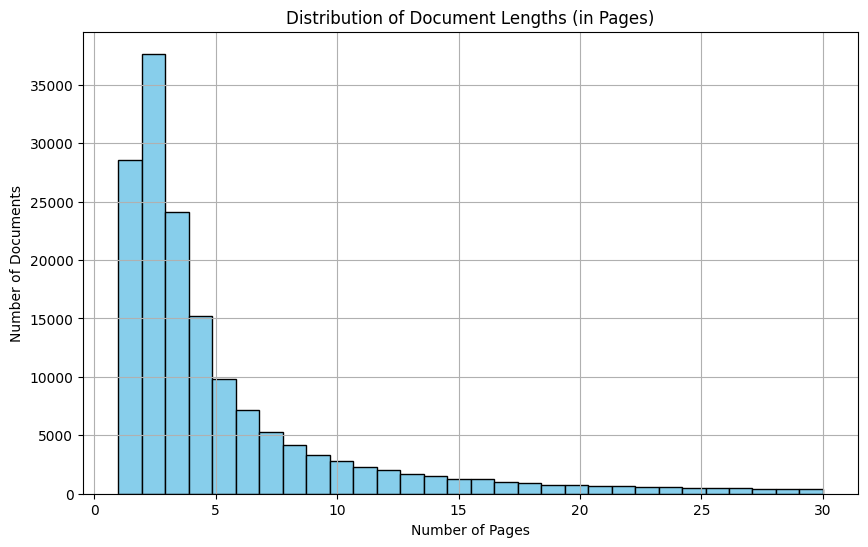

count    156571.000000
mean          4.975660
std           5.351258
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max          30.000000
Name: num_pages, dtype: float64


In [9]:
# Histogram visualization
plt.figure(figsize=(10, 6))
plt.hist(df_sorted["num_pages"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Document Lengths (in Pages)")
plt.xlabel("Number of Pages")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()

print(df_sorted["num_pages"].describe())

## Defining functions

The following cell defines functions for extracting the document texts, preprocessing, and for computing similar document pairs in blocks to avoid memory issues.

In [3]:
def extract_document(inventory_number, start_page, end_page, base_path="../data/txt/"):
    """
    Extracts the text from a transcription file for a given inventory number,
    between specified page numbers (inclusive), skipping the 24-line disclaimer.
    
    Parameters:
        inventory_number (str or int): The inventory number to identify the file.
        start_page (int): The first page of the document.
        end_page (int): The last page of the document (inclusive).
        base_path (str): The folder path where .txt files are stored.
    
    Returns:
        str: Extracted document text.
    """
    file_path = os.path.join(base_path, f"{inventory_number}.txt")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} not found.")

    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()[24:]  # skip disclaimer lines

    # Format page tags for matching
    def page_tag(page_number):
        return f"#+ NL-HaNA_1.04.02_{int(inventory_number)}_{str(page_number).zfill(4)}.xml"

    start_tag = page_tag(start_page)
    end_tag = page_tag(end_page + 1)

    # Track whether we’re inside the document section
    capturing = False
    collected_lines = []

    for line in lines:
        stripped = line.strip()

        if stripped == start_tag:
            capturing = True
            continue
        elif stripped == end_tag:
            break

        # Dont include the page separators in the document text
        if capturing and not stripped.startswith("#+"):
            collected_lines.append(line)

    return "".join(collected_lines).strip()


def filter_and_tokenize(text):
    # Character-level preprocessing
    text = text.lower()
    text = deaccent(text)
    text = strip_multiple_whitespaces(text)

    # Tokenization
    tokens = simple_tokenize(text)

    # Token-level filtering
    tokens = [strip_punctuation(t) for t in tokens]
    tokens = [t for t in tokens if t]  # Remove empty after stripping punctuation
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens (length <= 1)

    return tokens


def process_documents(df, txt_folder_path, min_tokens=0, max_tokens=None):
    """
    Processes and tokenizes documents from text files based on page ranges.

    Parameters:
        df (DataFrame): Contains ID's, inventory numbers and page ranges.
        txt_folder_path (str): Path to folder with .txt files.
        min_tokens (int): Minimum number of tokens required to keep the document.
        max_tokens (int or None): Maximum number of tokens allowed. If None, no upper limit.

    Returns:
        dict: Document ID to list of tokens.
    """

    # Initialize a dictionary to store the processed data
    processed_docs = {}

    # Loop through each row in the dataframe with tqdm for a progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Documents", unit="document"):
        # Get the ID, inventory number, start page, and end page
        id = row["ove_id"]
        inventory_number = row["vwz_inventarisnummer"]
        start_page = int(row["start_page"])
        end_page = int(row["end_page"])

        # Construct the path to the .txt file for this inventory number
        txt_file_path = os.path.join(txt_folder_path, f"{inventory_number}.txt")

        # Check if the file exists
        if not os.path.exists(txt_file_path):
            print(f"Warning: File {txt_file_path} not found. Skipping...")
            continue

        # Extract the document content based on the start and end pages
        document_content = extract_document(inventory_number, start_page, end_page, base_path=txt_folder_path)

        # Filter and tokenize the content
        tokens = filter_and_tokenize(document_content)

        # Skip documents that don't meet the token threshold
        if len(tokens) < min_tokens:
            continue
        if max_tokens is not None and len(tokens) > max_tokens:
            continue

        # Generate a unique document ID: combining inventory number, start, and end page
        doc_id = f"{id}_{inventory_number}_{start_page}_{end_page}"

        # Store the results in the dictionary using the document ID
        processed_docs[doc_id] = tokens

    return processed_docs


def compute_similar_pairs_blockwise_tfidf(matrix, threshold=0.90, block_size=5000):
    """
    Computes high cosine similarity pairs in a block-wise manner to avoid memory issues.

    Parameters:
        matrix (scipy.sparse matrix): TF-IDF matrix.
        threshold (float): Similarity threshold to retain.
        block_size (int): Number of documents per block.

    Returns:
        List of (i, j, score) tuples with similarity ≥ threshold.
    """

    n_docs = matrix.shape[0] # Total number of documents
    similar_pairs = []

    # Outer loop
    for i_start in tqdm(range(0, n_docs, block_size), desc="Outer block"):
        i_end = min(i_start + block_size, n_docs)
        block_i = matrix[i_start:i_end]

        # Inner loop
        for j_start in range(i_start, n_docs, block_size):
            j_end = min(j_start + block_size, n_docs)
            block_j = matrix[j_start:j_end]

            # Compute cosine similarity between block_i and block_j
            # Result is a sparse matrix (only nonzero similarities are stored)
            sim_matrix = cosine_similarity(block_i, block_j, dense_output=False)

            # Get indices of nonzero similarities
            i_idx, j_idx = sim_matrix.nonzero()
            scores = sim_matrix.data

            # Iterate through the nonzero similarities
            for idx, (i_local, j_local, score) in enumerate(zip(i_idx, j_idx, scores)):
                # Convert local block indices to global indices in the full matrix
                i_global = i_start + i_local
                j_global = j_start + j_local

                # Only keep upper triangle and above threshold
                if i_global < j_global and score >= threshold:
                    similar_pairs.append((i_global, j_global, score))

    return similar_pairs

def compute_similar_pairs_blockwise_bilstm(matrix, threshold=0.90, block_size=5000):
    """
    Computes high cosine similarity pairs in a block-wise manner to avoid memory issues.

    Parameters:
        matrix (np.ndarray): BiLSTM document vector matrix.
        threshold (float): Similarity threshold to retain.
        block_size (int): Number of documents per block.

    Returns:
        List of (i, j, score) tuples with similarity ≥ threshold.
    """

    n_docs = matrix.shape[0] # Total number of documents
    similar_pairs = []

    # Outer loop
    for i_start in tqdm(range(0, n_docs, block_size), desc="Outer block"):
        i_end = min(i_start + block_size, n_docs)
        block_i = matrix[i_start:i_end]

        # Inner loop
        for j_start in range(i_start, n_docs, block_size):
            j_end = min(j_start + block_size, n_docs)
            block_j = matrix[j_start:j_end]

            # Compute cosine similarity between block_i and block_j
            sim_matrix = cosine_similarity(block_i, block_j)

            i_idx, j_idx = sim_matrix.nonzero()
            scores = sim_matrix[i_idx, j_idx]

            # Iterate through the nonzero similarities
            for idx, (i_local, j_local, score) in enumerate(zip(i_idx, j_idx, scores)):
                # Convert local block indices to global indices in the full matrix
                i_global = i_start + i_local
                j_global = j_start + j_local

                # Only keep upper triangle and above threshold
                if i_global < j_global and score >= threshold:
                    similar_pairs.append((i_global, j_global, score))

    return similar_pairs

## Data preprocessing and subset selection

Here, the document token counts are visualised. The documents texts are retrieved using the process_documents() function. Only documents between 10 and 5000 tokens are displayed, as the token counts are very skewed with the majority being lower counts.

In [ ]:
txt_folder_path = "../data/txt"
tokenized_docs_10_to_5000 = process_documents(df_sorted, txt_folder_path, min_tokens=10, max_tokens=5000)

# Pickle dump for later use
with open(f"../data/documents_tokenized/tokenized_docs_10_to_5000.pkl", "wb") as f:
    pickle.dump(tokenized_docs_10_to_5000, f)

In [7]:
# Pickle load the processed documents
with open(f"../data/documents_tokenized/tokenized_docs_10_to_5000.pkl", "rb") as f:
    tokenized_docs_10_to_5000 = pickle.load(f)

A histogram visualisation of the distribution of length of the documents in token counts.

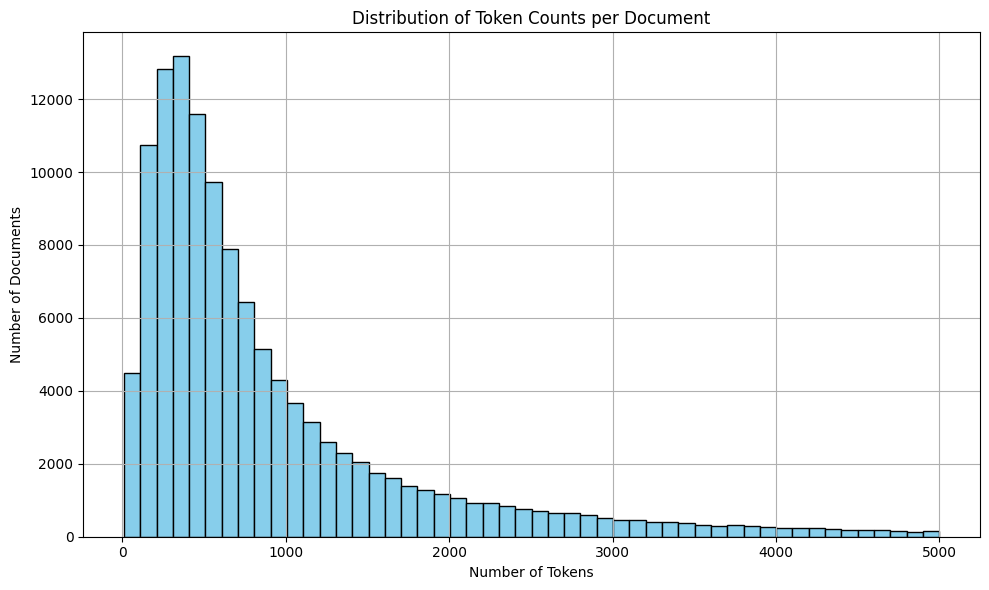

120456
10 4999


In [8]:
# Get lengths of each token list
token_lengths = [len(tokens) for tokens in tokenized_docs_10_to_5000.values()]
token_lengths_sorted = sorted(token_lengths)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(token_lengths_sorted, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Token Counts per Document")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(tokenized_docs_10_to_5000))
print(token_lengths_sorted[0], token_lengths_sorted[-1])

Load the texts for all documents within the 10 to 1000 token range. In the histogram above, notice that the large peak is within this range. This results in 86,038 documents, which is still a majority of the documents available. Thus to ensure model efficiency and prevent memory issues, it has been decided to use this subset of the documents.

In [ ]:
txt_folder_path = "../data/txt"
tokenized_docs_10_to_1000 = process_documents(df_sorted, txt_folder_path, min_tokens=10, max_tokens=1000)

# Pickle dump for later use
with open(f"../data/documents_tokenized/tokenized_docs_10_to_1000.pkl", "wb") as f:
    pickle.dump(tokenized_docs_10_to_1000, f)

In [4]:
# Pickle load the processed documents
with open(f"../data/documents_tokenized/tokenized_docs_10_to_1000.pkl", "rb") as f:
    tokenized_docs_10_to_1000 = pickle.load(f)

# TF-IDF Model

The loaded tokenized documents are converted to strings, and the TF-IDF model is created. The resulting TF-IDF vectorizer and matrix are saved for later use.

In [5]:
documents = []

for doc_id, tokens in tokenized_docs_10_to_1000.items():
    text = " ".join(tokens)  # Convert token list to string
    documents.append((doc_id, text))

# Extract texts and IDs
doc_ids, texts = zip(*documents)

# Fit TF-IDF on full filtered dataset
vectorizer = TfidfVectorizer(max_features=None, max_df=0.85)
tfidf_matrix = vectorizer.fit_transform(texts)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Save the TF-IDF matrix
with open("../data/TF-IDF/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)

# Save the vectorizer
with open("../data/TF-IDF/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

TF-IDF matrix shape: (86038, 1014013)


In [6]:
# Load the TF-IDF matrix
with open("../data/TF-IDF/tfidf_matrix.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)

# Load the vectorizer
with open("../data/TF-IDF/tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

Here, the similar pairs (or potential (near)-duplicates) are found by using cosine similarity on the TF-IDF matrix. The pairs with a cosine similarity score of 0.9 or above are stored for later use (for the evaluation). To find these pairs, the earlier defined compute_similar_pairs_blockwise_tfidf() function is used, which processes the TF-IDF matrix in blocks to prevent memory issues that could occur when processing the whole matrix at once.

In [ ]:
# Compute similar pairs
similar_pairs = compute_similar_pairs_blockwise_tfidf(matrix=tfidf_matrix, threshold=0.90, block_size=8000)

# Save similar pairs
with open("../data/TF-IDF/similar_pairs_with_scores.pkl", "wb") as f:
    pickle.dump(similar_pairs, f)

print(f"Saved {len(similar_pairs)} similar pairs with cosine similarity ≥ 0.90")


Outer block: 100%|██████████| 11/11 [30:39<00:00, 167.24s/it]

Saved 7778 similar pairs with cosine similarity ≥ 0.90


In [ ]:
# Load the similar pairs
with open("../data/TF-IDF/similar_pairs_with_scores.pkl", "rb") as f:
    similar_pairs = pickle.load(f)

## Evaluating TF-IDF's similar pairs

Below, a fuzzy score ratio is used to confirm whether the high-cosine similarity scoring pairs are actually similar. Thereafter, a histogram visualisation is displayed to compare the cosine scores with the fuzzy scores. The fuzzy score ratio determines how similar two texts are based on the amount of character edits necessary to transform one text into the other.

41207_1554_1_16 <-> 41204_1554_1_17 | Cosine: 0.939, Fuzzy: 90
42392_1566_91_106 <-> 42393_1566_91_106 | Cosine: 1.000, Fuzzy: 100
80567_3024_3_19 <-> 80579_3024_1_20 | Cosine: 0.961, Fuzzy: 93
80567_3024_3_19 <-> 80583_3024_5_21 | Cosine: 0.931, Fuzzy: 88
80583_3024_5_21 <-> 80579_3024_1_20 | Cosine: 0.976, Fuzzy: 95
88223_3274_1_17 <-> 88219_3274_1_17 | Cosine: 1.000, Fuzzy: 100
66438_2630_3_19 <-> 66441_2630_1_18 | Cosine: 0.930, Fuzzy: 90
93708_3495_1_19 <-> 93711_3495_1_20 | Cosine: 0.980, Fuzzy: 92
93708_3495_1_19 <-> 93725_3495_1_19 | Cosine: 1.000, Fuzzy: 100
93725_3495_1_19 <-> 93711_3495_1_20 | Cosine: 0.980, Fuzzy: 92


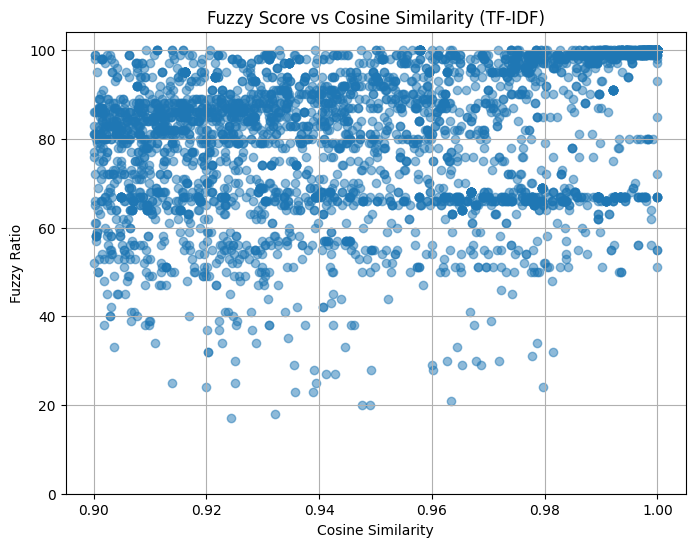

In [30]:
# Lists for storing the scores
cosine_scores_full = []
fuzzy_scores_full = []

# Get the cosine scores, and calculate the fuzzy scores for the similar pairs
for i, j, cosine in similar_pairs:
    text1 = texts[i]
    text2 = texts[j]

    fuzzy_score = fuzz.ratio(text1, text2)

    cosine_scores_full.append(cosine)
    fuzzy_scores_full.append(fuzzy_score)

# Combine everything into one list for easy sorting
scored_pairs = [
    (i, j, cosine, fuzzy_score)
    for (i, j, cosine), fuzzy_score in zip(similar_pairs, fuzzy_scores_full)
]

# Display some scored pairs for inspection
for i, j, cosine, fuzzy_score in scored_pairs[-10:]:
    print(f"{doc_ids[i]} <-> {doc_ids[j]} | Cosine: {cosine:.3f}, Fuzzy: {fuzzy_score}")

# Plotting the histogram of cosine scores vs fuzzy scores
plt.figure(figsize=(8, 6))
plt.scatter(cosine_scores_full, fuzzy_scores_full, alpha=0.5)
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Ratio")
plt.title("Fuzzy Score vs Cosine Similarity (TF-IDF)")
plt.grid(True)
plt.ylim(0, None)
plt.show()

The cell below prints the top 5 and bottom 5 fuzzy scoring similar pairs. The top fuzzy scoring texts are basically complete duplicates. Notice that for the lowest scoring pairs that the texts are very different, except for the fact that one certain word occurs very often. This word, "idem", means something that has previously been mentioned. Because these documents have such a high frequency of that word, the TF-IDF score was probably very high, resulting in the high cosine similarity score.

In [31]:
# Sort by fuzzy match score (descending)
scored_pairs_sorted = sorted(scored_pairs, key=lambda x: x[3], reverse=True)

# Number of top and bottom examples to inspect
n = 5

print("\n--- TOP FUZZY SCORES ---\n")
for i, j, cosine, fuzzy_score in scored_pairs_sorted[:n]:
    tokens1 = tokenized_docs_10_to_1000[doc_ids[i]]
    tokens2 = tokenized_docs_10_to_1000[doc_ids[j]]

    print(f"IDs: {doc_ids[i]} <-> {doc_ids[j]}")
    print(f"Cosine Similarity: {cosine:.3f}, Fuzzy Score: {fuzzy_score}")
    print(f"Token count: {len(tokens1)} vs {len(tokens2)}")
    print("\nText 1:\n", " ".join(tokens1))
    print("\nText 2:\n", " ".join(tokens2))
    print("=" * 100)

print("\n--- LOWEST FUZZY SCORES (but high cosine) ---\n")
for i, j, cosine, fuzzy_score in scored_pairs_sorted[-n:]:
    tokens1 = tokenized_docs_10_to_1000[doc_ids[i]]
    tokens2 = tokenized_docs_10_to_1000[doc_ids[j]]

    print(f"IDs: {doc_ids[i]} <-> {doc_ids[j]}")
    print(f"Cosine Similarity: {cosine:.3f}, Fuzzy Score: {fuzzy_score}")
    print(f"Token count: {len(tokens1)} vs {len(tokens2)}")
    print("\nText 1:\n", " ".join(tokens1))
    print("\nText 2:\n", " ".join(tokens2))
    print("=" * 100)


--- TOP FUZZY SCORES ---

IDs: 99629_3720_32_32 <-> 99607_3720_32_32
Cosine Similarity: 1.000, Fuzzy Score: 100
Token count: 194 vs 194

Text 1:
 nagezeen augustinus pires en adam christoffelsz luijk klerken als getuijgen die de minu te deeses nevens de attestanten en mij tekretaris hebben onderteekend onderstond welk getuijgd was getekend maatheze tekretaars heden februarij anno kompareerde voor mij wilhelmus gijsbertus van zitter eerste gesw klerk van politie en justitie deses kommandements present de nate noemene getuigen de lodewijk elgenhuisen kapitein ter zee en marinus van vlaanderen kapitein luitenant beide bescheiden op het tans alhier in de baij gean kert leggend na retourschip slot ter hooge dewelken tesamen en ider van hen in het bijzonder verklaerden waeragtig tewesen dat bij gedaene visitatie van desijlen van gem bodem door expresse gekommiteerden alhier de volgende gebreeken en be nodigheeden daer aen ontdekt zijn die noodzakelijk dienen verholpen en voorzien te worden 

## Saving TF-IDF's (near)-duplicates to csv files

Below, the similar pairs from the TF-IDF model with fuzzy scores of 80 or higher are regarded as actual (near)-duplicates and stored in csv files. These csv files contain all necessary information, from document ID to start and end page numbers, the cosine and fuzzy score, and the complete texts of the documents. 

Though there is an important distinction made, as most of the document pairs occur when the documents are read from (parts of) the exact same texts. That is, when the inventory number is the same, and the start and end pages overlap. For example, one document can be page 1 through 10, and the matched duplicate document can be pages 3 through 11 of the same inventory number. Additionally, some pages can be empty, so there is a chance that the documents are completely the same text. In these cases of overlap, the results are stored in a separate csv file than those that are not overlapping.

In [35]:
fuzzy_score_thresh = 80

# Extract the inv_number and startpage and endpage from the document ID, which is structured as ID_invnumber_startpage_endpage
def parse_doc_id(doc_id):
    parts = doc_id.split('_')
    inv_number = parts[1]
    start_page = int(parts[2])
    end_page = int(parts[3])
    return inv_number, start_page, end_page

# Function that checks if page ranges overlap
def page_ranges_overlap(start1, end1, start2, end2):
    return not (end1 < start2 or end2 < start1)

# Make sure the results directory exists
os.makedirs('../results', exist_ok=True)

# Prepare file structure
csv_files = {
    '../results/TFIDF_overlap.csv': [],
    '../results/TFIDF_no_overlap.csv': []
}

# Process document pairs
for i, j, cosine, fuzzy_score in scored_pairs_sorted:
    if fuzzy_score < fuzzy_score_thresh:
        continue  # Skip pairs below threshold
    
    doc_id_1 = doc_ids[i]
    doc_id_2 = doc_ids[j]

    inv_1, start_1, end_1 = parse_doc_id(doc_id_1)
    inv_2, start_2, end_2 = parse_doc_id(doc_id_2)

    same_inv = inv_1 == inv_2
    pages_overlap = page_ranges_overlap(start_1, end_1, start_2, end_2)

    row = [
        doc_id_1, inv_1, start_1, end_1,
        doc_id_2, inv_2, start_2, end_2,
        cosine, fuzzy_score,
        " ".join(tokenized_docs_10_to_1000[doc_id_1]),
        " ".join(tokenized_docs_10_to_1000[doc_id_2])
    ]

    if same_inv and pages_overlap:
        csv_files['../results/TFIDF_overlap.csv'].append(row)
    else:
        csv_files['../results/TFIDF_no_overlap.csv'].append(row)

# Write CSVs
for filename, rows in csv_files.items():
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([
            'doc_id_1', 'inv_number_1', 'start_page_1', 'end_page_1',
            'doc_id_2', 'inv_number_2', 'start_page_2', 'end_page_2',
            'cosine_similarity', 'fuzzy_score', 'text_1', 'text_2'
        ])
        writer.writerows(rows)

print("CSV files saved to ../results/:")
for filename in csv_files.keys():
    print(f" - {filename} ({len(csv_files[filename])} rows)")


CSV files saved to ../results/:
 - ../results/TFIDF_overlap.csv (5986 rows)
 - ../results/TFIDF_no_overlap.csv (254 rows)


This code prints the top 10 rows from both the overlapping results as well as the no_overlap results.

In [36]:
file_paths = [
    '../results/TFIDF_overlap.csv',
    '../results/TFIDF_no_overlap.csv'
]

for file_path in file_paths:
    print(f"\nReading: {file_path}")
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for i, row in enumerate(reader):
            if i >= 10:
                break
            print(f"\nRow {i + 1}:")
            print(f"Cosine Similarity: {row['cosine_similarity']}")
            print(f"Fuzzy Score: {row['fuzzy_score']}")
            print(f"Text 1: {row['text_1']}")
            print(f"Text 2: {row['text_2']}")


Reading: ../results/TFIDF_overlap.csv

Row 1:
Cosine Similarity: 1.0000000000000002
Fuzzy Score: 100
Text 1: nagezeen augustinus pires en adam christoffelsz luijk klerken als getuijgen die de minu te deeses nevens de attestanten en mij tekretaris hebben onderteekend onderstond welk getuijgd was getekend maatheze tekretaars heden februarij anno kompareerde voor mij wilhelmus gijsbertus van zitter eerste gesw klerk van politie en justitie deses kommandements present de nate noemene getuigen de lodewijk elgenhuisen kapitein ter zee en marinus van vlaanderen kapitein luitenant beide bescheiden op het tans alhier in de baij gean kert leggend na retourschip slot ter hooge dewelken tesamen en ider van hen in het bijzonder verklaerden waeragtig tewesen dat bij gedaene visitatie van desijlen van gem bodem door expresse gekommiteerden alhier de volgende gebreeken en be nodigheeden daer aen ontdekt zijn die noodzakelijk dienen verholpen en voorzien te worden teweeten van een groote en een voorma

# BiLSTM Model

Start with loading the documents. Earlier in the notebook these were stored as pickle file, so now it only has to be loaded.

In [4]:
documents = []

# Pickle load the processed documents
with open(f"../data/documents_tokenized/tokenized_docs_10_to_1000.pkl", "rb") as f:
    tokenized_docs_10_to_1000 = pickle.load(f)

for doc_id, tokens in tokenized_docs_10_to_1000.items():
    text = " ".join(tokens)  # convert token list to string
    documents.append((doc_id, text))

# Extract texts and IDs
doc_ids, texts = zip(*documents)

This loads the vocabulary and embedding matrix which was pretrained using the Word2Vec model by GLOBALISE (van Wissen, Leon, and GLOBALISE. “GLOBALISE Word2vec Experiment”. Zenodo, March 17, 2025. https://doi.org/10.5281/zenodo.15038313.)

The embedding matrix loaded here was trained with different parameter values as originally in their experiment. Such as the context window or the minimum amount of occurences of a word. The exact details about this are explained in the thesis.

In [6]:
# Load vocabulary
with open("../data/embeddings/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

# Load embedding matrix
embedding_matrix = torch.load("../data/embeddings/embedding_matrix.pt")

C:\Users\chris\AppData\Local\Temp\ipykernel_4436\790178752.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding_matrix = torch.load("../data/embeddings/embedding_ma

Below, the BiLSTM model is created. It processes the documents in batches, resulting in document vectors for each document.

In [6]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128):
        super().__init__()

        # Dimensions of the embedding matrix: (vocab_size, embedding_dim)
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Create an embedding layer and initialize it with pretrained weights
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, input_ids, lengths):
        # input_ids: (batch_size, seq_len) – token indices for each document
        # lengths: (batch_size,) – actual lengths before padding

        embedded = self.embedding(input_ids)

        # Pack the sequence so the LSTM ignores padded elements
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.bilstm(packed) # hidden: (num_directions=2, batch_size, hidden_size)
        forward = hidden[0]    # Forward LSTM's final hidden state
        backward = hidden[1]   # Backward LSTM's final hidden state
        
        # Concatenate forward and backward hidden states
        return torch.cat((forward, backward), dim=1)  # (batch, hidden_size*2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = BiLSTMEncoder(embedding_matrix, hidden_size=128).to(device)
model.eval()

# Prepare document IDs and token sequences
all_doc_ids = list(tokenized_docs_10_to_1000.keys())
all_token_lists = list(tokenized_docs_10_to_1000.values())

# Storage for output vectors
document_vectors = {}
batch_size = 32

# Batch processing
for i in tqdm(range(0, len(all_doc_ids), batch_size)):
    doc_ids_batch = all_doc_ids[i:i + batch_size]
    token_lists_batch = all_token_lists[i:i + batch_size]

    # Convert each document's tokens to a tensor of indices
    input_ids = [
        torch.tensor([vocab.get(token, 0) for token in tokens], dtype=torch.long)
        for tokens in token_lists_batch
    ]

    lengths = torch.tensor([len(seq) for seq in input_ids], dtype=torch.long)
    padded_input = pad_sequence(input_ids, batch_first=True)  # (batch_size, max_seq_len)

    # Move tensors to GPU/CPU
    padded_input = padded_input.to(device)
    lengths = lengths.to(device)

    # Run through model
    with torch.no_grad():
        doc_vecs = model(padded_input, lengths)  # (batch_size, hidden_size * 2)

    # Store vectors
    for doc_id, vec in zip(doc_ids_batch, doc_vecs):
        document_vectors[doc_id] = vec.cpu().numpy()

# Save final dictionary of document vectors
with open("../data/BiLSTM/document_vectors.pkl", "wb") as f:
    pickle.dump(document_vectors, f)

print(f"Saved {len(document_vectors)} document vectors to '../data/BiLSTM/document_vectors.pkl'")


100%|██████████| 2689/2689 [10:24<00:00,  4.31it/s]


Saved 86038 document vectors to '../data/BiLSTM/document_vectors.pkl'


In [7]:
# Load document vectors
with open("../data/BiLSTM/document_vectors.pkl", "rb") as f:
    document_vectors = pickle.load(f)

# Prepare matrix
doc_ids = list(document_vectors.keys())
bilstm_matrix = np.stack([document_vectors[doc_id] for doc_id in doc_ids])

bilstm_matrix.shape

(86038, 256)

Here, the similar pairs (or potential (near)-duplicates) are found by using cosine similarity on the BiLSTM matrix. The pairs with a cosine similarity score of 0.9 or above are stored for later use (for the evaluation). To find these pairs, the ealier defined compute_similar_pairs_blockwise_bilstm() function is used, which processes the BiLSTM matrix in blocks to prevent memory issues that could occur when processing the whole matrix at once.

In [8]:
# Compute similar pairs
similar_pairs = compute_similar_pairs_blockwise_bilstm(matrix=bilstm_matrix, threshold=0.90, block_size=8000)

# Save similar pairs
with open("../data/BiLSTM/similar_pairs_with_scores.pkl", "wb") as f:
    pickle.dump(similar_pairs, f)

print(f"Saved {len(similar_pairs)} similar pairs with cosine similarity ≥ 0.90")

Outer block: 100%|██████████| 11/11 [1:52:32<00:00, 613.83s/it] 


Saved 361239 similar pairs with cosine similarity ≥ 0.90


In [5]:
# Load the similar pairs
with open("../data/BiLSTM/similar_pairs_with_scores.pkl", "rb") as f:
    similar_pairs = pickle.load(f)

## Evaluating BiLSTM's similar pairs

Below, a fuzzy score ratio is used to confirm whether the high-cosine similarity scoring pairs are actually similar. Thereafter, a histogram visualisation is displayed to compare the cosine scores with the fuzzy scores.

94578_3530_1_14 <-> 88740_3295_5_20 | Cosine: 0.928, Fuzzy: 16
106771_7538_1_15 <-> 106767_7538_1_15 | Cosine: 1.000, Fuzzy: 100
106771_7538_1_15 <-> 106746_7538_1_15 | Cosine: 1.000, Fuzzy: 100
106767_7538_1_15 <-> 106746_7538_1_15 | Cosine: 1.000, Fuzzy: 100
70383_2737_4_19 <-> 88740_3295_5_20 | Cosine: 0.931, Fuzzy: 53
65531_2605_1_16 <-> 65516_2605_1_16 | Cosine: 1.000, Fuzzy: 100
42392_1566_91_106 <-> 42393_1566_91_106 | Cosine: 1.000, Fuzzy: 100
88223_3274_1_17 <-> 88219_3274_1_17 | Cosine: 1.000, Fuzzy: 100
93708_3495_1_19 <-> 93725_3495_1_19 | Cosine: 1.000, Fuzzy: 100
93550_3487_2_25 <-> 101782_3800_2_25 | Cosine: 0.902, Fuzzy: 44


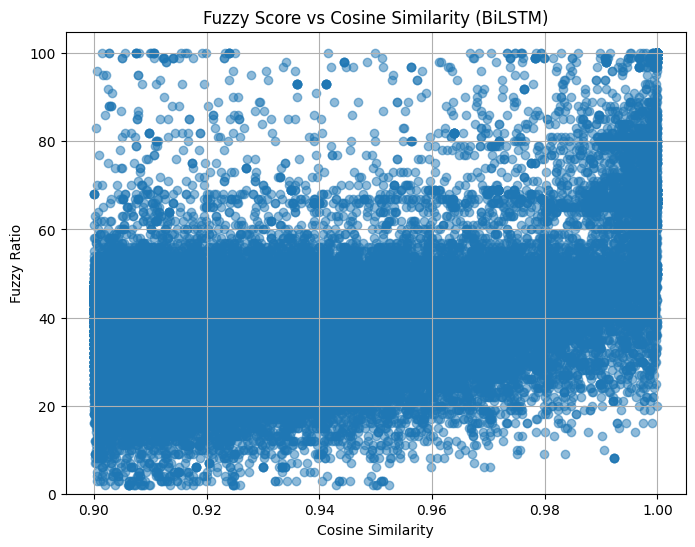

In [6]:
# Lists for storing the scores
cosine_scores_full = []
fuzzy_scores_full = []

# Get the cosine scores, and calculate the fuzzy scores for the similar pairs
for i, j, cosine in similar_pairs:
    text1 = texts[i]
    text2 = texts[j]

    fuzzy_score = fuzz.ratio(text1, text2)

    cosine_scores_full.append(cosine)
    fuzzy_scores_full.append(fuzzy_score)

# Combine everything into one list for easy sorting
scored_pairs = [
    (i, j, cosine, fuzzy_score)
    for (i, j, cosine), fuzzy_score in zip(similar_pairs, fuzzy_scores_full)
]

# Display some scored pairs for inspection
for i, j, cosine, fuzzy_score in scored_pairs[-10:]:
    print(f"{doc_ids[i]} <-> {doc_ids[j]} | Cosine: {cosine:.3f}, Fuzzy: {fuzzy_score}")

# Plotting the histogram of cosine scores vs fuzzy scores
plt.figure(figsize=(8, 6))
plt.scatter(cosine_scores_full, fuzzy_scores_full, alpha=0.5)
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Ratio")
plt.title("Fuzzy Score vs Cosine Similarity (BiLSTM)")
plt.grid(True)
plt.ylim(0, None)
plt.show()

The cell below prints the top 5 and bottom 5 fuzzy scoring similar pairs. The top fuzzy scoring texts are basically complete duplicates. For the lowest scoring pairs, it is likely that these are caused by their difference in length. One of the documents is only 10 tokens, which is the shortest possible text length in the dataset used. And the documents it is matched with are much larger, resulting in the low fuzzy scores because of the high amount of edits necessary to transform one text into the other.

In [7]:
# Sort by fuzzy match score (descending)
scored_pairs_sorted = sorted(scored_pairs, key=lambda x: x[3], reverse=True)

# Number of top and bottom examples to inspect
n = 5

print("\n--- TOP FUZZY SCORES ---\n")
for i, j, cosine, fuzzy_score in scored_pairs_sorted[:n]:
    tokens1 = tokenized_docs_10_to_1000[doc_ids[i]]
    tokens2 = tokenized_docs_10_to_1000[doc_ids[j]]

    print(f"IDs: {doc_ids[i]} <-> {doc_ids[j]}")
    print(f"Cosine Similarity: {cosine:.3f}, Fuzzy Score: {fuzzy_score}")
    print(f"Token count: {len(tokens1)} vs {len(tokens2)}")
    print("\nText 1:\n", " ".join(tokens1))
    print("\nText 2:\n", " ".join(tokens2))
    print("=" * 100)

print("\n--- LOWEST FUZZY SCORES (but high cosine) ---\n")
for i, j, cosine, fuzzy_score in scored_pairs_sorted[-n:]:
    tokens1 = tokenized_docs_10_to_1000[doc_ids[i]]
    tokens2 = tokenized_docs_10_to_1000[doc_ids[j]]

    print(f"IDs: {doc_ids[i]} <-> {doc_ids[j]}")
    print(f"Cosine Similarity: {cosine:.3f}, Fuzzy Score: {fuzzy_score}")
    print(f"Token count: {len(tokens1)} vs {len(tokens2)}")
    print("\nText 1:\n", " ".join(tokens1))
    print("\nText 2:\n", " ".join(tokens2))
    print("=" * 100)


--- TOP FUZZY SCORES ---

IDs: 99629_3720_32_32 <-> 99607_3720_32_32
Cosine Similarity: 1.000, Fuzzy Score: 100
Token count: 194 vs 194

Text 1:
 nagezeen augustinus pires en adam christoffelsz luijk klerken als getuijgen die de minu te deeses nevens de attestanten en mij tekretaris hebben onderteekend onderstond welk getuijgd was getekend maatheze tekretaars heden februarij anno kompareerde voor mij wilhelmus gijsbertus van zitter eerste gesw klerk van politie en justitie deses kommandements present de nate noemene getuigen de lodewijk elgenhuisen kapitein ter zee en marinus van vlaanderen kapitein luitenant beide bescheiden op het tans alhier in de baij gean kert leggend na retourschip slot ter hooge dewelken tesamen en ider van hen in het bijzonder verklaerden waeragtig tewesen dat bij gedaene visitatie van desijlen van gem bodem door expresse gekommiteerden alhier de volgende gebreeken en be nodigheeden daer aen ontdekt zijn die noodzakelijk dienen verholpen en voorzien te worden 

## Saving BiLSTM's (near)-duplicates to csv files

Below, the similar pairs from the BiLSTM model with fuzzy scores of 80 or higher are regarded as actual (near)-duplicates and stored in csv files. These csv files contain all necessary information, from document ID to start and end page numbers, the cosine and fuzzy score, and the complete texts of the documents. 

Though there is an important distinction made, as most of the document pairs occur when the documents are read from (parts of) the exact same texts. That is, when the inventory number is the same, and the start and end pages overlap. For example, one document can be page 1 through 10, and the matched duplicate document can be pages 3 through 11 of the same inventory number. Additionally, some pages can be empty, so there is a chance that the documents are completely the same text. In these cases of overlap, the results are stored in a separate csv file than those that are not overlapping.

In [8]:
fuzzy_score_thresh = 80

# Extract the inv_number and startpage and endpage from the document ID, which is structured as ID_invnumber_startpage_endpage
def parse_doc_id(doc_id):
    parts = doc_id.split('_')
    inv_number = parts[1]
    start_page = int(parts[2])
    end_page = int(parts[3])
    return inv_number, start_page, end_page

# Function that checks if page ranges overlap
def page_ranges_overlap(start1, end1, start2, end2):
    return not (end1 < start2 or end2 < start1)

# Make sure the results directory exists
os.makedirs('../results', exist_ok=True)

# Prepare file structure
csv_files = {
    '../results/BiLSTM_overlap.csv': [],
    '../results/BiLSTM_no_overlap.csv': []
}

# Process document pairs
for i, j, cosine, fuzzy_score in scored_pairs_sorted:
    if fuzzy_score < fuzzy_score_thresh:
        continue  # Skip pairs below threshold
    
    doc_id_1 = doc_ids[i]
    doc_id_2 = doc_ids[j]

    inv_1, start_1, end_1 = parse_doc_id(doc_id_1)
    inv_2, start_2, end_2 = parse_doc_id(doc_id_2)

    same_inv = inv_1 == inv_2
    pages_overlap = page_ranges_overlap(start_1, end_1, start_2, end_2)

    row = [
        doc_id_1, inv_1, start_1, end_1,
        doc_id_2, inv_2, start_2, end_2,
        cosine, fuzzy_score,
        " ".join(tokenized_docs_10_to_1000[doc_id_1]),
        " ".join(tokenized_docs_10_to_1000[doc_id_2])
    ]

    if same_inv and pages_overlap:
        csv_files['../results/BiLSTM_overlap.csv'].append(row)
    else:
        csv_files['../results/BiLSTM_no_overlap.csv'].append(row)

# Write CSVs
for filename, rows in csv_files.items():
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([
            'doc_id_1', 'inv_number_1', 'start_page_1', 'end_page_1',
            'doc_id_2', 'inv_number_2', 'start_page_2', 'end_page_2',
            'cosine_similarity', 'fuzzy_score', 'text_1', 'text_2'
        ])
        writer.writerows(rows)

print("CSV files saved to ../results/:")
for filename in csv_files.keys():
    print(f" - {filename} ({len(csv_files[filename])} rows)")


CSV files saved to ../results/:
 - ../results/BiLSTM_overlap.csv (4725 rows)
 - ../results/BiLSTM_no_overlap.csv (257 rows)


This code prints the top 10 rows from both the overlapping results as well as the no_overlap results.

In [12]:
file_paths = [
    '../results/BiLSTM_overlap.csv',
    '../results/BiLSTM_no_overlap.csv'
]

for file_path in file_paths:
    print(f"\nReading: {file_path}")
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for i, row in enumerate(reader):
            if i >= 10:
                break
            print(f"\nRow {i + 1}:")
            print(f"Cosine Similarity: {row['cosine_similarity']}")
            print(f"Fuzzy Score: {row['fuzzy_score']}")
            print(f"Text 1: {row['text_1']}")
            print(f"Text 2: {row['text_2']}")


Reading: ../results/BiLSTM_overlap.csv

Row 1:
Cosine Similarity: 1.0000004
Fuzzy Score: 100
Text 1: nagezeen augustinus pires en adam christoffelsz luijk klerken als getuijgen die de minu te deeses nevens de attestanten en mij tekretaris hebben onderteekend onderstond welk getuijgd was getekend maatheze tekretaars heden februarij anno kompareerde voor mij wilhelmus gijsbertus van zitter eerste gesw klerk van politie en justitie deses kommandements present de nate noemene getuigen de lodewijk elgenhuisen kapitein ter zee en marinus van vlaanderen kapitein luitenant beide bescheiden op het tans alhier in de baij gean kert leggend na retourschip slot ter hooge dewelken tesamen en ider van hen in het bijzonder verklaerden waeragtig tewesen dat bij gedaene visitatie van desijlen van gem bodem door expresse gekommiteerden alhier de volgende gebreeken en be nodigheeden daer aen ontdekt zijn die noodzakelijk dienen verholpen en voorzien te worden teweeten van een groote en een voormaazijls d

# Hybrid Model

Start with loading the documents. Earlier in the notebook these were stored as pickle file, so now it only has to be loaded.

In [4]:
documents = []

# Pickle load the processed documents
with open(f"../data/documents_tokenized/tokenized_docs_10_to_1000.pkl", "rb") as f:
    tokenized_docs_10_to_1000 = pickle.load(f)

for doc_id, tokens in tokenized_docs_10_to_1000.items():
    text = " ".join(tokens)  # convert token list to string
    documents.append((doc_id, text))

# Extract texts and IDs
doc_ids, texts = zip(*documents)

This loads the vocabulary and embedding matrix which was pretrained using the Word2Vec model by GLOBALISE (van Wissen, Leon, and GLOBALISE. “GLOBALISE Word2vec Experiment”. Zenodo, March 17, 2025. https://doi.org/10.5281/zenodo.15038313.)

The embedding matrix loaded here was trained with different parameter values as originally in their experiment. Such as the context window or the minimum amount of occurences of a word.

In [5]:
# Load vocabulary
with open("../data/embeddings/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

# Load embedding matrix
embedding_matrix = torch.load("../data/embeddings/embedding_matrix.pt")

C:\Users\chris\AppData\Local\Temp\ipykernel_7448\790178752.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding_matrix = torch.load("../data/embeddings/embedding_ma

Also load the TF-IDF vectorizer which is to be used to weigh the embeddings in the hybrid model.

In [6]:
with open("../data/TF-IDF/tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

with open("../data/TF-IDF/tfidf_matrix.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)

Below, the Hybrid model is created. It processes the documents in batches, resulting in document vectors for each document. The difference between the BiLSTM and the Hybrid models is that the embeddings used in the Hybrid model are weighed by multiplying with the tf-idf scores.

In [8]:
class HybridBiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128):
        super().__init__()

        # Dimensions of the embedding matrix: (vocab_size, embedding_dim)
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Create an embedding layer and initialize it with pretrained weights
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)

        # Freeze embeddings
        self.embedding.weight.requires_grad = False

        self.bilstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, input_ids, tfidf_weights, lengths):
        # input_ids: (batch_size, seq_len) – token indices for each document
        # tfidf_weights: (batch_size, seq_len) – tf-idf weights for each token
        # lengths: (batch_size,) – actual lengths before padding

        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embedding_dim)

        # Weight embeddings by tf-idf: multiply each word vector by its tf-idf score
        weighted_embedded = embedded * tfidf_weights.unsqueeze(2)  # (batch_size, seq_len, embedding_dim)

        # Pack the sequence so the LSTM ignores padded elements
        packed = pack_padded_sequence(weighted_embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.bilstm(packed)  # hidden: (num_directions=2, batch_size, hidden_size)
        
        forward = hidden[0]    # Forward LSTM's final hidden state
        backward = hidden[1]   # Backward LSTM's final hidden state

        # Concatenate forward and backward hidden states
        return torch.cat((forward, backward), dim=1)  # (batch, hidden_size*2)
    

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = HybridBiLSTMEncoder(embedding_matrix, hidden_size=128).to(device)
model.eval()

# Prepare data
all_doc_ids = list(tokenized_docs_10_to_1000.keys())
all_token_lists = list(tokenized_docs_10_to_1000.values())

# TF-IDF vocab for lookup
tfidf_vocab = tfidf_vectorizer.vocabulary_

# Storage for output vectors
document_vectors = {}
batch_size = 32

# Batch processing
for i in tqdm(range(0, len(all_doc_ids), batch_size)):
    doc_ids_batch = all_doc_ids[i:i + batch_size]
    token_lists_batch = all_token_lists[i:i + batch_size]

    # Convert token lists to tensor of embedding vocab indices
    input_ids = [
        torch.tensor([vocab.get(token, 0) for token in tokens], dtype=torch.long)
        for tokens in token_lists_batch
    ]
    
    lengths = torch.tensor([len(seq) for seq in input_ids], dtype=torch.long)

    # Pad sequences to max length in batch
    padded_input = pad_sequence(input_ids, batch_first=True).to(device)
    lengths = lengths.to(device)

    # Prepare TF-IDF weights tensor matching input_ids shape
    tfidf_weights = []
    for idx, tokens in enumerate(token_lists_batch):
        doc_index = i + idx  # Global index in TF-IDF matrix
        tfidf_vec = tfidf_matrix[doc_index]  # Sparse row vector
        
        # Convert sparse row vector to dense array for indexing
        dense_tfidf = tfidf_vec.toarray().flatten()  # shape: (vocab_size,)

        # Lookup tf-idf weights for tokens using tfidf_vocab,
        # fallback 0 if token missing in tfidf_vocab
        token_weights = [
            dense_tfidf[tfidf_vocab[token]] if token in tfidf_vocab else 0.0
            for token in tokens
        ]
        tfidf_weights.append(torch.tensor(token_weights, dtype=torch.float))

    # Pad TF-IDF weights to max length in batch
    padded_tfidf = pad_sequence(tfidf_weights, batch_first=True).to(device)  # (batch, max_seq_len)

    # Forward pass through model
    with torch.no_grad():
        doc_vecs = model(padded_input, padded_tfidf, lengths)  # (batch, hidden_size*2)

    # Store resulting document vectors
    for doc_id, vec in zip(doc_ids_batch, doc_vecs):
        document_vectors[doc_id] = vec.cpu().numpy()

# --- Save all document vectors ---
os.makedirs("../data/Hybrid", exist_ok=True)
with open("../data/Hybrid/document_vectors.pkl", "wb") as f:
    pickle.dump(document_vectors, f)

print(f"Saved {len(document_vectors)} document vectors to '../data/Hybrid/document_vectors.pkl'")


100%|██████████| 2689/2689 [37:29<00:00,  1.20it/s] 


Saved 86038 document vectors to '../data/Hybrid/document_vectors.pkl'


In [5]:
# Load document vectors
with open("../data/Hybrid/document_vectors.pkl", "rb") as f:
    document_vectors = pickle.load(f)

# Prepare matrix
doc_ids = list(document_vectors.keys())
hybrid_matrix = np.stack([document_vectors[doc_id] for doc_id in doc_ids])

hybrid_matrix.shape

(86038, 256)

Here, the similar pairs (or potential (near)-duplicates) are found by using cosine similarity on the Hybrid matrix. The pairs with a cosine similarity score of 0.95 or above are stored for later use (for the evaluation). In the previous two models, a cosine similarity of 0.9 was used, but that threshold causes memory issues when used for the hybrid model, as it finds a much larger amount of potential duplicates. Thus, for this reason, the cosine threshold is set to 0.95 for the Hybrid model. To find these pairs, the ealier defined compute_similar_pairs_blockwise_bilstm() function is used, which processes the Hybrid matrix in blocks to prevent memory issues that could occur when processing the whole matrix at once.

In [ ]:
# Compute similar pairs
similar_pairs = compute_similar_pairs_blockwise_bilstm(matrix=hybrid_matrix, threshold=0.95, block_size=8000)

# Save similar pairs
with open("../data/Hybrid/similar_pairs_with_scores.pkl", "wb") as f:
    pickle.dump(similar_pairs, f)

print(f"Saved {len(similar_pairs)} similar pairs with cosine similarity ≥ 0.95")

Saved 7781847 similar pairs with cosine similarity ≥ 0.95


In [5]:
# Load the similar pairs
with open("../data/Hybrid/similar_pairs_with_scores.pkl", "rb") as f:
    similar_pairs = pickle.load(f)

## Evaluating Hybrid's similar pairs

Below, a fuzzy score ratio is used to confirm whether the high-cosine similarity scoring pairs are actually similar. Thereafter, a histogram visualisation is displayed to compare the cosine scores with the fuzzy scores.

169518_1173_69_87 <-> 102248_3821_594_616 | Cosine: 0.974, Fuzzy: 43
93708_3495_1_19 <-> 93725_3495_1_19 | Cosine: 1.000, Fuzzy: 100
141831_8313_20_39 <-> 102248_3821_594_616 | Cosine: 0.976, Fuzzy: 36
141831_8313_20_39 <-> 83724_3123_31_54 | Cosine: 0.956, Fuzzy: 39
119550_8852_471_493 <-> 13040_1378_1745_1772 | Cosine: 0.982, Fuzzy: 41
169904_7557_35_57 <-> 102248_3821_594_616 | Cosine: 0.958, Fuzzy: 43
102248_3821_594_616 <-> 83724_3123_31_54 | Cosine: 0.970, Fuzzy: 43
102248_3821_594_616 <-> 90023_3342_354_379 | Cosine: 0.953, Fuzzy: 43
102248_3821_594_616 <-> 71013_2753_1127_1153 | Cosine: 0.950, Fuzzy: 43
93550_3487_2_25 <-> 101782_3800_2_25 | Cosine: 0.972, Fuzzy: 44


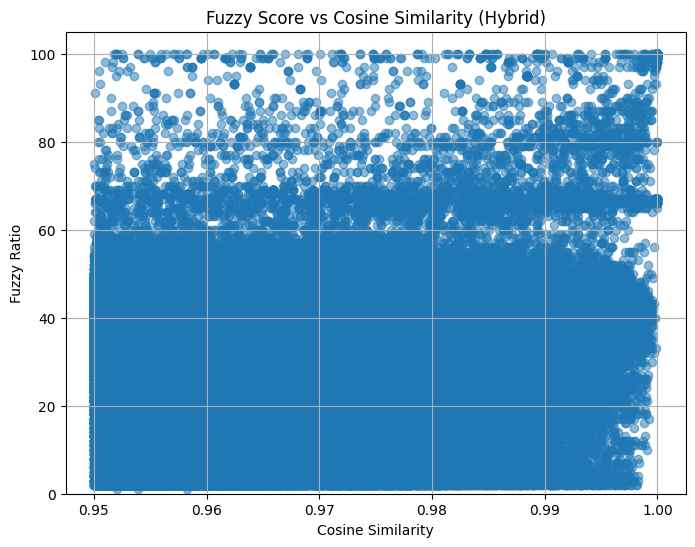

In [6]:
# Lists for storing the scores
cosine_scores_full = []
fuzzy_scores_full = []

# Get the cosine scores, and calculate the fuzzy scores for the similar pairs
for i, j, cosine in similar_pairs:
    text1 = texts[i]
    text2 = texts[j]

    fuzzy_score = fuzz.ratio(text1, text2)

    cosine_scores_full.append(cosine)
    fuzzy_scores_full.append(fuzzy_score)

# Combine everything into one list for easy sorting
scored_pairs = [
    (i, j, cosine, fuzzy_score)
    for (i, j, cosine), fuzzy_score in zip(similar_pairs, fuzzy_scores_full)
]

# Display some scored pairs for inspection
for i, j, cosine, fuzzy_score in scored_pairs[-10:]:
    print(f"{doc_ids[i]} <-> {doc_ids[j]} | Cosine: {cosine:.3f}, Fuzzy: {fuzzy_score}")

# Plotting the histogram of cosine scores vs fuzzy scores
plt.figure(figsize=(8, 6))
plt.scatter(cosine_scores_full, fuzzy_scores_full, alpha=0.5)
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Ratio")
plt.title("Fuzzy Score vs Cosine Similarity (Hybrid)")
plt.grid(True)
plt.ylim(0, None)
plt.show()

The cell below prints the top 5 and bottom 5 fuzzy scoring similar pairs. The top fuzzy scoring texts are basically complete duplicates. For the lowest scoring pairs, it is likely that these are caused by their difference in length. One of the documents is only 10 tokens, which is the shortest possible text length in the dataset used. And the documents it is matched with are much larger, resulting in the low fuzzy scores because of the high amount of edits necessary to transform one text into the other. This is similar to the BiLSTM model results.

In [7]:
# Sort by fuzzy match score (descending)
scored_pairs_sorted = sorted(scored_pairs, key=lambda x: x[3], reverse=True)

# Number of top and bottom examples to inspect
n = 5

print("\n--- TOP FUZZY SCORES ---\n")
for i, j, cosine, fuzzy_score in scored_pairs_sorted[:n]:
    tokens1 = tokenized_docs_10_to_1000[doc_ids[i]]
    tokens2 = tokenized_docs_10_to_1000[doc_ids[j]]

    print(f"IDs: {doc_ids[i]} <-> {doc_ids[j]}")
    print(f"Cosine Similarity: {cosine:.3f}, Fuzzy Score: {fuzzy_score}")
    print(f"Token count: {len(tokens1)} vs {len(tokens2)}")
    print("\nText 1:\n", " ".join(tokens1))
    print("\nText 2:\n", " ".join(tokens2))
    print("=" * 100)

print("\n--- LOWEST FUZZY SCORES (but high cosine) ---\n")
for i, j, cosine, fuzzy_score in scored_pairs_sorted[-n:]:
    tokens1 = tokenized_docs_10_to_1000[doc_ids[i]]
    tokens2 = tokenized_docs_10_to_1000[doc_ids[j]]

    print(f"IDs: {doc_ids[i]} <-> {doc_ids[j]}")
    print(f"Cosine Similarity: {cosine:.3f}, Fuzzy Score: {fuzzy_score}")
    print(f"Token count: {len(tokens1)} vs {len(tokens2)}")
    print("\nText 1:\n", " ".join(tokens1))
    print("\nText 2:\n", " ".join(tokens2))
    print("=" * 100)


--- TOP FUZZY SCORES ---

IDs: 99629_3720_32_32 <-> 99607_3720_32_32
Cosine Similarity: 1.000, Fuzzy Score: 100
Token count: 194 vs 194

Text 1:
 nagezeen augustinus pires en adam christoffelsz luijk klerken als getuijgen die de minu te deeses nevens de attestanten en mij tekretaris hebben onderteekend onderstond welk getuijgd was getekend maatheze tekretaars heden februarij anno kompareerde voor mij wilhelmus gijsbertus van zitter eerste gesw klerk van politie en justitie deses kommandements present de nate noemene getuigen de lodewijk elgenhuisen kapitein ter zee en marinus van vlaanderen kapitein luitenant beide bescheiden op het tans alhier in de baij gean kert leggend na retourschip slot ter hooge dewelken tesamen en ider van hen in het bijzonder verklaerden waeragtig tewesen dat bij gedaene visitatie van desijlen van gem bodem door expresse gekommiteerden alhier de volgende gebreeken en be nodigheeden daer aen ontdekt zijn die noodzakelijk dienen verholpen en voorzien te worden 

## Saving Hybrid's (near)-duplicates to csv files

Below, the similar pairs from the Hybrid model with fuzzy scores of 80 or higher are regarded as actual (near)-duplicates and stored in csv files. These csv files contain all necessary information, from document ID to start and end page numbers, the cosine and fuzzy score, and the complete texts of the documents. 

Though there is an important distinction made, as most of the document pairs occur when the documents are read from (parts of) the exact same texts. That is, when the inventory number is the same, and the start and end pages overlap. For example, one document can be page 1 through 10, and the matched duplicate document can be pages 3 through 11 of the same inventory number. Additionally, some pages can be empty, so there is a chance that the documents are completely the same text. In these cases of overlap, the results are stored in a separate csv file than those that are not overlapping.

In [8]:
fuzzy_score_thresh = 80

# Extract the inv_number and startpage and endpage from the document ID, which is structured as ID_invnumber_startpage_endpage
def parse_doc_id(doc_id):
    parts = doc_id.split('_')
    inv_number = parts[1]
    start_page = int(parts[2])
    end_page = int(parts[3])
    return inv_number, start_page, end_page

# Function that checks if page ranges overlap
def page_ranges_overlap(start1, end1, start2, end2):
    return not (end1 < start2 or end2 < start1)

# Make sure the results directory exists
os.makedirs('../results', exist_ok=True)

# Prepare file structure
csv_files = {
    '../results/Hybrid_overlap.csv': [],
    '../results/Hybrid_no_overlap.csv': []
}

# Process document pairs
for i, j, cosine, fuzzy_score in scored_pairs_sorted:
    if fuzzy_score < fuzzy_score_thresh:
        continue  # Skip pairs below threshold
    
    doc_id_1 = doc_ids[i]
    doc_id_2 = doc_ids[j]

    inv_1, start_1, end_1 = parse_doc_id(doc_id_1)
    inv_2, start_2, end_2 = parse_doc_id(doc_id_2)

    same_inv = inv_1 == inv_2
    pages_overlap = page_ranges_overlap(start_1, end_1, start_2, end_2)

    row = [
        doc_id_1, inv_1, start_1, end_1,
        doc_id_2, inv_2, start_2, end_2,
        cosine, fuzzy_score,
        " ".join(tokenized_docs_10_to_1000[doc_id_1]),
        " ".join(tokenized_docs_10_to_1000[doc_id_2])
    ]

    if same_inv and pages_overlap:
        csv_files['../results/Hybrid_overlap.csv'].append(row)
    else:
        csv_files['../results/Hybrid_no_overlap.csv'].append(row)

# Write CSVs
for filename, rows in csv_files.items():
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([
            'doc_id_1', 'inv_number_1', 'start_page_1', 'end_page_1',
            'doc_id_2', 'inv_number_2', 'start_page_2', 'end_page_2',
            'cosine_similarity', 'fuzzy_score', 'text_1', 'text_2'
        ])
        writer.writerows(rows)

print("CSV files saved to ../results/:")
for filename in csv_files.keys():
    print(f" - {filename} ({len(csv_files[filename])} rows)")


CSV files saved to ../results/:
 - ../results/Hybrid_overlap.csv (4989 rows)
 - ../results/Hybrid_no_overlap.csv (334 rows)


This code prints the top 10 rows from both the overlapping results as well as the no_overlap results.

In [10]:
file_paths = [
    '../results/Hybrid_overlap.csv',
    '../results/Hybrid_no_overlap.csv'
]

for file_path in file_paths:
    print(f"\nReading: {file_path}")
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for i, row in enumerate(reader):
            if i >= 10:
                break
            print(f"\nRow {i + 1}:")
            print(f"Cosine Similarity: {row['cosine_similarity']}")
            print(f"Fuzzy Score: {row['fuzzy_score']}")
            print(f"Text 1: {row['text_1']}")
            print(f"Text 2: {row['text_2']}")


Reading: ../results/Hybrid_overlap.csv

Row 1:
Cosine Similarity: 0.9999999
Fuzzy Score: 100
Text 1: nagezeen augustinus pires en adam christoffelsz luijk klerken als getuijgen die de minu te deeses nevens de attestanten en mij tekretaris hebben onderteekend onderstond welk getuijgd was getekend maatheze tekretaars heden februarij anno kompareerde voor mij wilhelmus gijsbertus van zitter eerste gesw klerk van politie en justitie deses kommandements present de nate noemene getuigen de lodewijk elgenhuisen kapitein ter zee en marinus van vlaanderen kapitein luitenant beide bescheiden op het tans alhier in de baij gean kert leggend na retourschip slot ter hooge dewelken tesamen en ider van hen in het bijzonder verklaerden waeragtig tewesen dat bij gedaene visitatie van desijlen van gem bodem door expresse gekommiteerden alhier de volgende gebreeken en be nodigheeden daer aen ontdekt zijn die noodzakelijk dienen verholpen en voorzien te worden teweeten van een groote en een voormaazijls d

# Synthetic dataset

A synthetic dataset is created to evaluate the performances of the duplicate detection models. For this, 1000 documents are randomly selected and copied to match with 100 percent similarity. Next, a random amount of tokens (equally distributed from 1 to 99% of the tokens) are removed from the matched document copies, resulting in document pairs with a wide range of similarity levels, from near-duplicates to highly different.

This is necessary to be able to measure how many of the actual duplicates the models can detect, as for the actual dataset the amount of duplicates is unknown.

Start with loading the documents and creating the synthetic dataset.

In [12]:
documents = []

# Pickle load the processed documents
with open(f"../data/documents_tokenized/tokenized_docs_10_to_1000.pkl", "rb") as f:
    tokenized_docs_10_to_1000 = pickle.load(f)

for doc_id, tokens in tokenized_docs_10_to_1000.items():
    text = " ".join(tokens)  # convert token list to string
    documents.append((doc_id, text))

# Extract texts and IDs
doc_ids, texts = zip(*documents)

# Randomly pick 1000 base documents
sample_size = 1000
base_sample = random.sample(list(tokenized_docs_10_to_1000.items()), sample_size)

# Define similarity levels evenly spaced
num_levels = 100
similarity_levels = np.linspace(0.01, 0.99, num_levels)
docs_per_level = sample_size // num_levels

# Randomly remove tokens to simulate similarity
def randomly_remove_tokens(tokens, keep_ratio):
    n = len(tokens)
    keep_n = max(1, int(n * keep_ratio))  # ensure at least 1 token
    if keep_n >= n:
        return tokens  # unchanged if removing 0
    indices_to_keep = sorted(random.sample(range(n), keep_n))
    return [tokens[i] for i in indices_to_keep]

# Build synthetic pairs
synthetic_pairs = []
doc_counter = 0

for level in similarity_levels:
    for _ in range(docs_per_level):
        doc_id, tokens = base_sample[doc_counter]
        doc_counter += 1

        text1 = " ".join(tokens)

        # Create modified version
        if level == 1.0:
            tokens_modified = tokens[:]  # exact copy
        else:
            tokens_modified = randomly_remove_tokens(tokens, level)

        text2 = " ".join(tokens_modified)

        # Assign a new synthetic ID
        mod_id = f"{doc_id}_sim{int(level * 100)}"

        # Fuzzy similarity (for reference)
        fuzzy = fuzz.ratio(text1, text2)

        # Add to list
        synthetic_pairs.append((doc_id, mod_id, text1, text2, fuzzy))

print(f"Created {len(synthetic_pairs)} synthetic pairs.")

# Make sure output folder exists
output_dir = "../data/synthetic"
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
output_path = os.path.join(output_dir, "synthetic_dataset.csv")
with open(output_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["doc_id_1", "doc_id_2", "text_1", "text_2", "fuzzy_similarity"])
    writer.writerows(synthetic_pairs)

print(f"Saved synthetic dataset to: {output_path}")


Created 1000 synthetic pairs.
Saved synthetic dataset to: ../data/synthetic\synthetic_dataset.csv


Plot a histogram of the fuzzy similarity score of all the 1000 synthetic document pairs.

Loaded 1000 fuzzy similarity scores from CSV.
Min: 1.00
Max: 100.00
Mean: 61.22


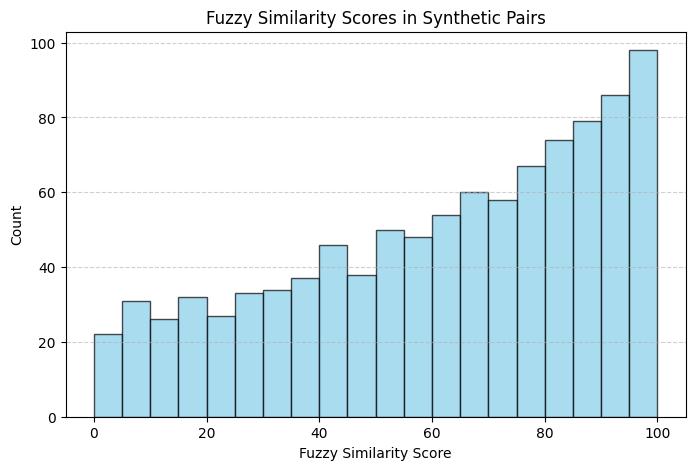

In [13]:
# Path to synthetic pairs CSV
csv_path = "../data/synthetic/synthetic_dataset.csv"

# Load fuzzy similarity scores from CSV
fuzzy_scores = []

with open(csv_path, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        fuzzy = float(row["fuzzy_similarity"])
        fuzzy_scores.append(fuzzy)

# Print basic stats
print(f"Loaded {len(fuzzy_scores)} fuzzy similarity scores from CSV.")
print(f"Min: {min(fuzzy_scores):.2f}")
print(f"Max: {max(fuzzy_scores):.2f}")
print(f"Mean: {sum(fuzzy_scores) / len(fuzzy_scores):.2f}")

# Plot histogram of fuzzy similarity scores
plt.figure(figsize=(8, 5))
plt.hist(fuzzy_scores, bins=20, range=(0, 100), alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Fuzzy Similarity Scores in Synthetic Pairs")
plt.xlabel("Fuzzy Similarity Score")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Synthetic dataset TF-IDF evaluation

Now the TF-IDF model will run on the synthetic dataset, and the resulting cosine similarity scores of the tf-idf will be displayed in a histogram overlapping with the actual fuzzy scores of the document pairs. The more the histograms overlap, the better the model's performance. Additionally, the fuzzy score is divided by 100 to have the same range as the cosine similarity score (0-1 instead of 0-100).

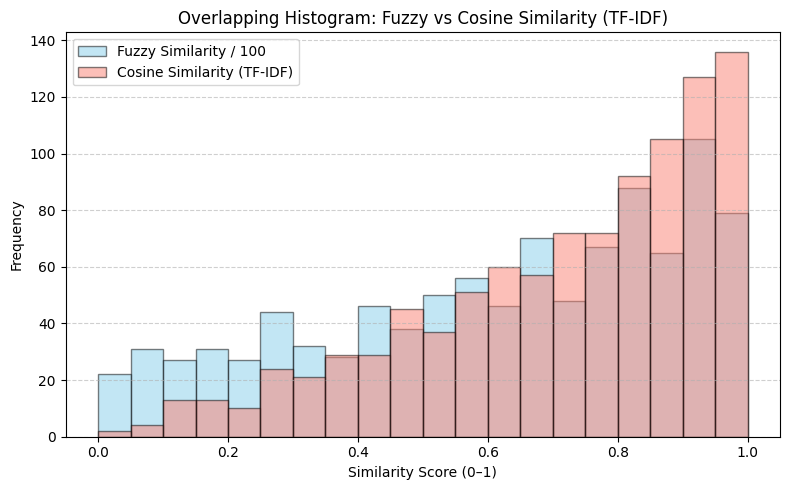

In [14]:
# Load TF-IDF Vectorizer
with open("../data/TF-IDF/tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Load synthetic pairs from CSV
csv_path = "../data/synthetic/synthetic_dataset.csv"
texts_1, texts_2, fuzzy_scores = [], [], []

with open(csv_path, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        texts_1.append(row["text_1"])
        texts_2.append(row["text_2"])
        fuzzy_scores.append(float(row["fuzzy_similarity"]) / 100.0)  # scale to [0, 1]

# Compute TF-IDF vectors
tfidf_1 = vectorizer.transform(texts_1)
tfidf_2 = vectorizer.transform(texts_2)

# Compute cosine similarity
cosine_scores = cosine_similarity(tfidf_1, tfidf_2).diagonal()

# Plot overlapping histograms
plt.figure(figsize=(8, 5))
plt.hist(fuzzy_scores, bins=20, range=(0, 1), alpha=0.5, label="Fuzzy Similarity / 100", color="skyblue", edgecolor="black")
plt.hist(cosine_scores, bins=20, range=(0, 1), alpha=0.5, label="Cosine Similarity (TF-IDF)", color="salmon", edgecolor="black")

plt.title("Overlapping Histogram: Fuzzy vs Cosine Similarity (TF-IDF)")
plt.xlabel("Similarity Score (0–1)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Calculating the accuracy and F1-score of the TF-IDF model performance on the synthetic dataset.

In [ ]:
threshold = 0.80

# Convert to binary match/non-match labels
fuzzy_labels = [1 if score >= threshold else 0 for score in fuzzy_scores]
cosine_labels = [1 if score >= threshold else 0 for score in cosine_scores]

# Evaluate classification performance
f1 = f1_score(fuzzy_labels, cosine_labels)
accuracy = accuracy_score(fuzzy_labels, cosine_labels)
precision = precision_score(fuzzy_labels, cosine_labels)
recall = recall_score(fuzzy_labels, cosine_labels)

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Threshold: 0.8
Accuracy:  0.8790
Precision: 0.7385
Recall:    0.9941
F1 Score:  0.8474


## Synthetic dataset BiLSTM evaluation

Now the BiLSTM model will run on the synthetic dataset, and the resulting cosine similarity scores of the BiLSTM will be displayed in a histogram overlapping with the actual fuzzy scores of the document pairs. The more the histograms overlap, the better the model's performance. Additionally, the fuzzy score is divided by 100 to have the same range as the cosine similarity score (0-1 instead of 0-100).

C:\Users\chris\AppData\Local\Temp\ipykernel_3996\1758084589.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding_matrix = torch.load("../data/embeddings/embedding_m

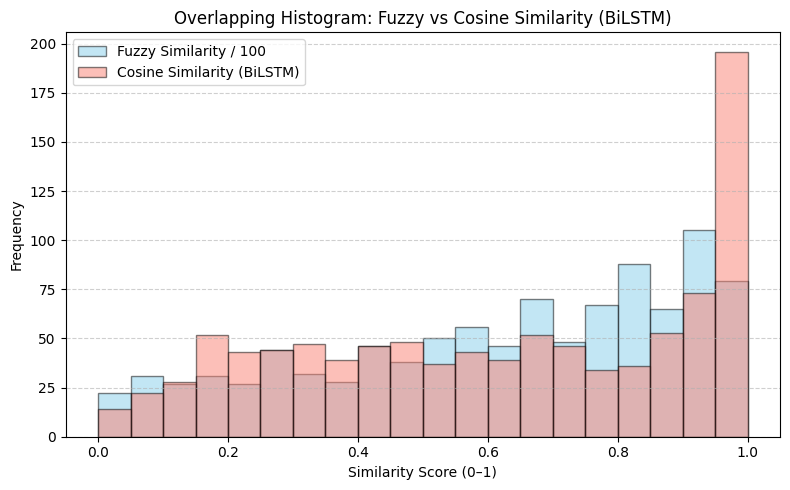

In [ ]:
# Load vocabulary
with open("../data/embeddings/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

# Load embedding matrix
embedding_matrix = torch.load("../data/embeddings/embedding_matrix.pt")

class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128):
        super().__init__()

        # Dimensions of the embedding matrix: (vocab_size, embedding_dim)
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Create an embedding layer and initialize it with pretrained weights
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, input_ids, lengths):
        # input_ids: (batch_size, seq_len) – token indices for each document
        # lengths: (batch_size,) – actual lengths before padding

        embedded = self.embedding(input_ids)

        # Pack the sequence so the LSTM ignores padded elements
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.bilstm(packed) # hidden: (num_directions=2, batch_size, hidden_size)
        forward = hidden[0]    # Forward LSTM's final hidden state
        backward = hidden[1]   # Backward LSTM's final hidden state
        
        # Concatenate forward and backward hidden states
        return torch.cat((forward, backward), dim=1)  # (batch, hidden_size*2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = BiLSTMEncoder(embedding_matrix, hidden_size=128).to(device)
model.eval()

# Load synthetic pairs
csv_path = "../data/synthetic/synthetic_dataset.csv"
pairs = []

with open(csv_path, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pairs.append((row["doc_id_1"], row["text_1"], row["doc_id_2"], row["text_2"], float(row["fuzzy_similarity"]) / 100.0))

# Tokenization function (split preprocessed text by space, convert to vocab IDs)
def text_to_tensor(text):
    tokens = text.strip().split()
    indices = torch.tensor([vocab.get(token, 0) for token in tokens], dtype=torch.long)
    return indices, len(indices)

# Batched encoding and cosine similarity
cosine_scores = []
fuzzy_scores = []

batch_size = 32
for i in tqdm(range(0, len(pairs), batch_size), desc="Processing pairs"):
    batch = pairs[i:i+batch_size]
    
    texts_1, texts_2 = [], []

    # Tokenize and index each text in the current batch
    for _, text1, _, text2, _ in batch:
        indices1, _ = text_to_tensor(text1)
        indices2, _ = text_to_tensor(text2)
        texts_1.append(indices1)
        texts_2.append(indices2)

    # Prepare lengths and padded tensors for BiLSTM input
    lengths_1 = torch.tensor([len(x) for x in texts_1], dtype=torch.long).to(device)
    lengths_2 = torch.tensor([len(x) for x in texts_2], dtype=torch.long).to(device)
    padded_1 = pad_sequence(texts_1, batch_first=True).to(device)
    padded_2 = pad_sequence(texts_2, batch_first=True).to(device)

    # Encode both sets of documents with the BiLSTM
    with torch.no_grad():
        vecs_1 = model(padded_1, lengths_1).cpu().numpy()
        vecs_2 = model(padded_2, lengths_2).cpu().numpy()

    # Compute cosine similarity between corresponding pairs
    cosine_batch = cosine_similarity(vecs_1, vecs_2).diagonal()
    cosine_scores.extend(cosine_batch)
    fuzzy_scores.extend([row[4] for row in batch])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(fuzzy_scores, bins=20, range=(0, 1), alpha=0.5, label="Fuzzy Similarity / 100", color="skyblue", edgecolor="black")
plt.hist(cosine_scores, bins=20, range=(0, 1), alpha=0.5, label="Cosine Similarity (BiLSTM)", color="salmon", edgecolor="black")
plt.title("Overlapping Histogram: Fuzzy vs Cosine Similarity (BiLSTM)")
plt.xlabel("Similarity Score (0–1)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Calculating the accuracy and F1-score of the BiLSTM model performance on the synthetic dataset.

In [18]:
threshold = 0.80

# Convert to binary match/non-match labels
fuzzy_labels = [1 if score >= threshold else 0 for score in fuzzy_scores]
cosine_labels = [1 if score >= threshold else 0 for score in cosine_scores]

# Evaluate classification performance
f1 = f1_score(fuzzy_labels, cosine_labels)
accuracy = accuracy_score(fuzzy_labels, cosine_labels)
precision = precision_score(fuzzy_labels, cosine_labels)
recall = recall_score(fuzzy_labels, cosine_labels)

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Threshold: 0.8
Accuracy:  0.8060
Precision: 0.6981
Recall:    0.7478
F1 Score:  0.7221


## Synthetic dataset Hybrid evaluation

Now the Hybrid model will run on the synthetic dataset, and the resulting cosine similarity scores of the Hybrid will be displayed in a histogram overlapping with the actual fuzzy scores of the document pairs. The more the histograms overlap, the better the model's performance. Additionally, the fuzzy score is divided by 100 to have the same range as the cosine similarity score (0-1 instead of 0-100).

C:\Users\chris\AppData\Local\Temp\ipykernel_8056\2408359888.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding_matrix = torch.load("../data/embeddings/embedding_m

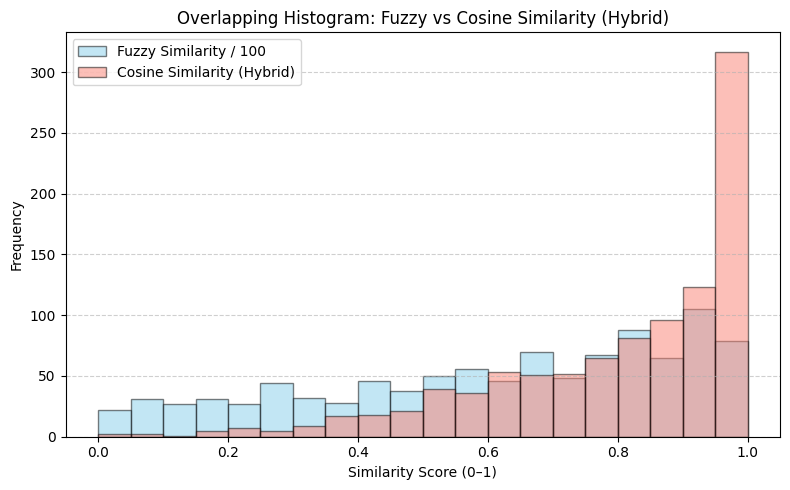

Threshold: 0.8
Accuracy:  0.6820
Precision: 0.5154
Recall:    0.9436
F1 Score:  0.6667


In [4]:
# Load vocabulary and embedding matrix
with open("../data/embeddings/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
embedding_matrix = torch.load("../data/embeddings/embedding_matrix.pt")

# Load TF-IDF vectorizer
with open("../data/TF-IDF/tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Define Hybrid BiLSTM Encoder
class HybridBiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128):
        super().__init__()

        # Dimensions of the embedding matrix: (vocab_size, embedding_dim)
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Create an embedding layer and initialize it with pretrained weights
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)

        # Freeze embeddings
        self.embedding.weight.requires_grad = False

        self.bilstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, input_ids, tfidf_weights, lengths):
        # input_ids: (batch_size, seq_len) – token indices for each document
        # tfidf_weights: (batch_size, seq_len) – tf-idf weights for each token
        # lengths: (batch_size,) – actual lengths before padding

        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embedding_dim)

        # Weight embeddings by tf-idf: multiply each word vector by its tf-idf score
        weighted_embedded = embedded * tfidf_weights.unsqueeze(2)  # (batch_size, seq_len, embedding_dim)

        # Pack the sequence so the LSTM ignores padded elements
        packed = pack_padded_sequence(weighted_embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.bilstm(packed)  # hidden: (num_directions=2, batch_size, hidden_size)
        
        forward = hidden[0]    # Forward LSTM's final hidden state
        backward = hidden[1]   # Backward LSTM's final hidden state

        # Concatenate forward and backward hidden states
        return torch.cat((forward, backward), dim=1)  # (batch, hidden_size*2)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridBiLSTMEncoder(embedding_matrix).to(device)
model.eval()

# Load synthetic dataset
csv_path = "../data/synthetic/synthetic_dataset.csv"
pairs = []
with open(csv_path, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pairs.append((row["text_1"], row["text_2"], float(row["fuzzy_similarity"]) / 100.0))

# Convert text to vocab indices and get TF-IDF weights
def text_to_tensor_with_tfidf(text, tfidf_vectorizer):
    tokens = text.strip().split()
    indices = [vocab.get(token, 0) for token in tokens]
    token_str = " ".join(tokens)

    # TF-IDF transform for this doc (sparse matrix)
    tfidf_vector = tfidf_vectorizer.transform([token_str])
    tfidf_dict = {token: tfidf_vector[0, tfidf_vectorizer.vocabulary_.get(token)]
                  for token in tokens if token in tfidf_vectorizer.vocabulary_}

    tfidf_weights = torch.tensor([tfidf_dict.get(token, 0.0) for token in tokens], dtype=torch.float32)
    indices = torch.tensor(indices, dtype=torch.long)
    return indices, tfidf_weights, len(indices)

# Batch processing
batch_size = 32
cosine_scores, fuzzy_scores = [], []

for i in tqdm(range(0, len(pairs), batch_size), desc="Hybrid on synthetic"):
    batch = pairs[i:i + batch_size]
    texts_1, texts_2 = [], []
    tfidf_1, tfidf_2 = [], []

    for text1, text2, _ in batch:
        ids1, tfidf_w1, _ = text_to_tensor_with_tfidf(text1, vectorizer)
        ids2, tfidf_w2, _ = text_to_tensor_with_tfidf(text2, vectorizer)
        texts_1.append(ids1)
        texts_2.append(ids2)
        tfidf_1.append(tfidf_w1)
        tfidf_2.append(tfidf_w2)

    lengths_1 = torch.tensor([len(x) for x in texts_1], dtype=torch.long).to(device)
    lengths_2 = torch.tensor([len(x) for x in texts_2], dtype=torch.long).to(device)
    padded_1 = pad_sequence(texts_1, batch_first=True).to(device)
    padded_2 = pad_sequence(texts_2, batch_first=True).to(device)
    tfidf_pad_1 = pad_sequence(tfidf_1, batch_first=True).to(device)
    tfidf_pad_2 = pad_sequence(tfidf_2, batch_first=True).to(device)

    with torch.no_grad():
        vecs_1 = model(padded_1, tfidf_pad_1, lengths_1).cpu().numpy()
        vecs_2 = model(padded_2, tfidf_pad_2, lengths_2).cpu().numpy()

    cosine_batch = cosine_similarity(vecs_1, vecs_2).diagonal()
    cosine_scores.extend(cosine_batch)
    fuzzy_scores.extend([row[2] for row in batch])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(fuzzy_scores, bins=20, range=(0, 1), alpha=0.5, label="Fuzzy Similarity / 100", color="skyblue", edgecolor="black")
plt.hist(cosine_scores, bins=20, range=(0, 1), alpha=0.5, label="Cosine Similarity (Hybrid)", color="salmon", edgecolor="black")
plt.title("Overlapping Histogram: Fuzzy vs Cosine Similarity (Hybrid)")
plt.xlabel("Similarity Score (0–1)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Evaluation
threshold = 0.80
fuzzy_labels = [1 if score >= threshold else 0 for score in fuzzy_scores]
cosine_labels = [1 if score >= threshold else 0 for score in cosine_scores]

f1 = f1_score(fuzzy_labels, cosine_labels)
accuracy = accuracy_score(fuzzy_labels, cosine_labels)
precision = precision_score(fuzzy_labels, cosine_labels)
recall = recall_score(fuzzy_labels, cosine_labels)

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")